In [19]:
import copy
import matplotlib.pyplot as plt
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
import numpy as np
import pandas as pd
import pycaret.classification as pc
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, f1_score, log_loss, roc_curve
from sklearn.model_selection import train_test_split, validation_curve


In [20]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto Kobe'

experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)

experiment_id = experiment.experiment_id

In [3]:
df_dev_preview = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')
data_cols = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
target_col = 'shot_made_flag'
df_dev_preview = df_dev_preview[data_cols].copy()
df_dev_preview.dropna(inplace=True)

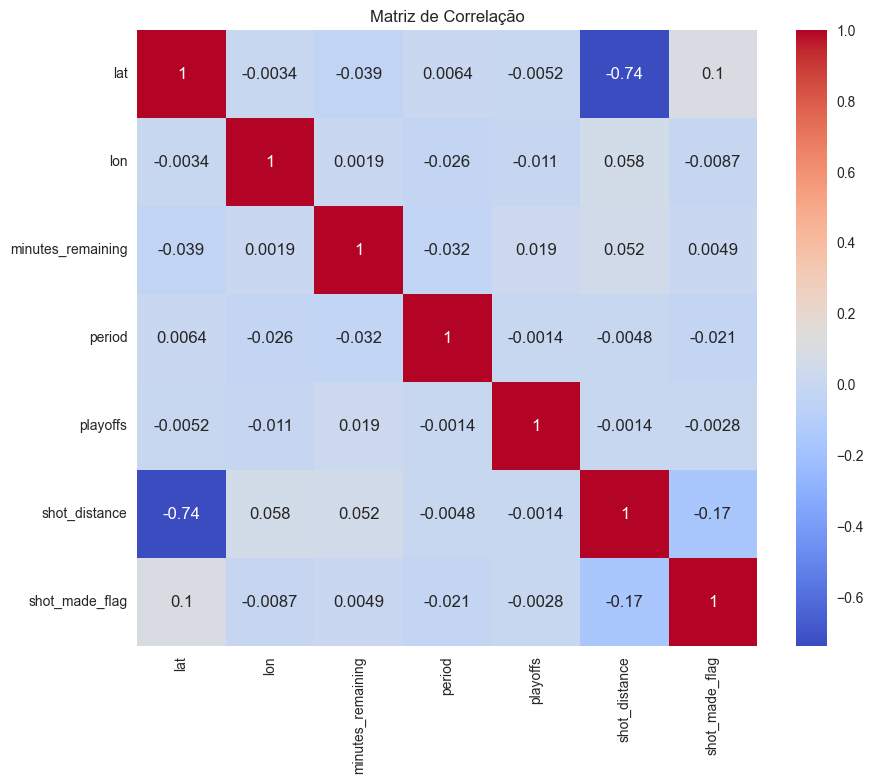

In [4]:
correlation_matrix = df_dev_preview.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

array([[<Axes: xlabel='lat', ylabel='lat'>,
        <Axes: xlabel='lon', ylabel='lat'>,
        <Axes: xlabel='minutes_remaining', ylabel='lat'>,
        <Axes: xlabel='period', ylabel='lat'>,
        <Axes: xlabel='playoffs', ylabel='lat'>,
        <Axes: xlabel='shot_distance', ylabel='lat'>,
        <Axes: xlabel='shot_made_flag', ylabel='lat'>],
       [<Axes: xlabel='lat', ylabel='lon'>,
        <Axes: xlabel='lon', ylabel='lon'>,
        <Axes: xlabel='minutes_remaining', ylabel='lon'>,
        <Axes: xlabel='period', ylabel='lon'>,
        <Axes: xlabel='playoffs', ylabel='lon'>,
        <Axes: xlabel='shot_distance', ylabel='lon'>,
        <Axes: xlabel='shot_made_flag', ylabel='lon'>],
       [<Axes: xlabel='lat', ylabel='minutes_remaining'>,
        <Axes: xlabel='lon', ylabel='minutes_remaining'>,
        <Axes: xlabel='minutes_remaining', ylabel='minutes_remaining'>,
        <Axes: xlabel='period', ylabel='minutes_remaining'>,
        <Axes: xlabel='playoffs', ylabel='minut

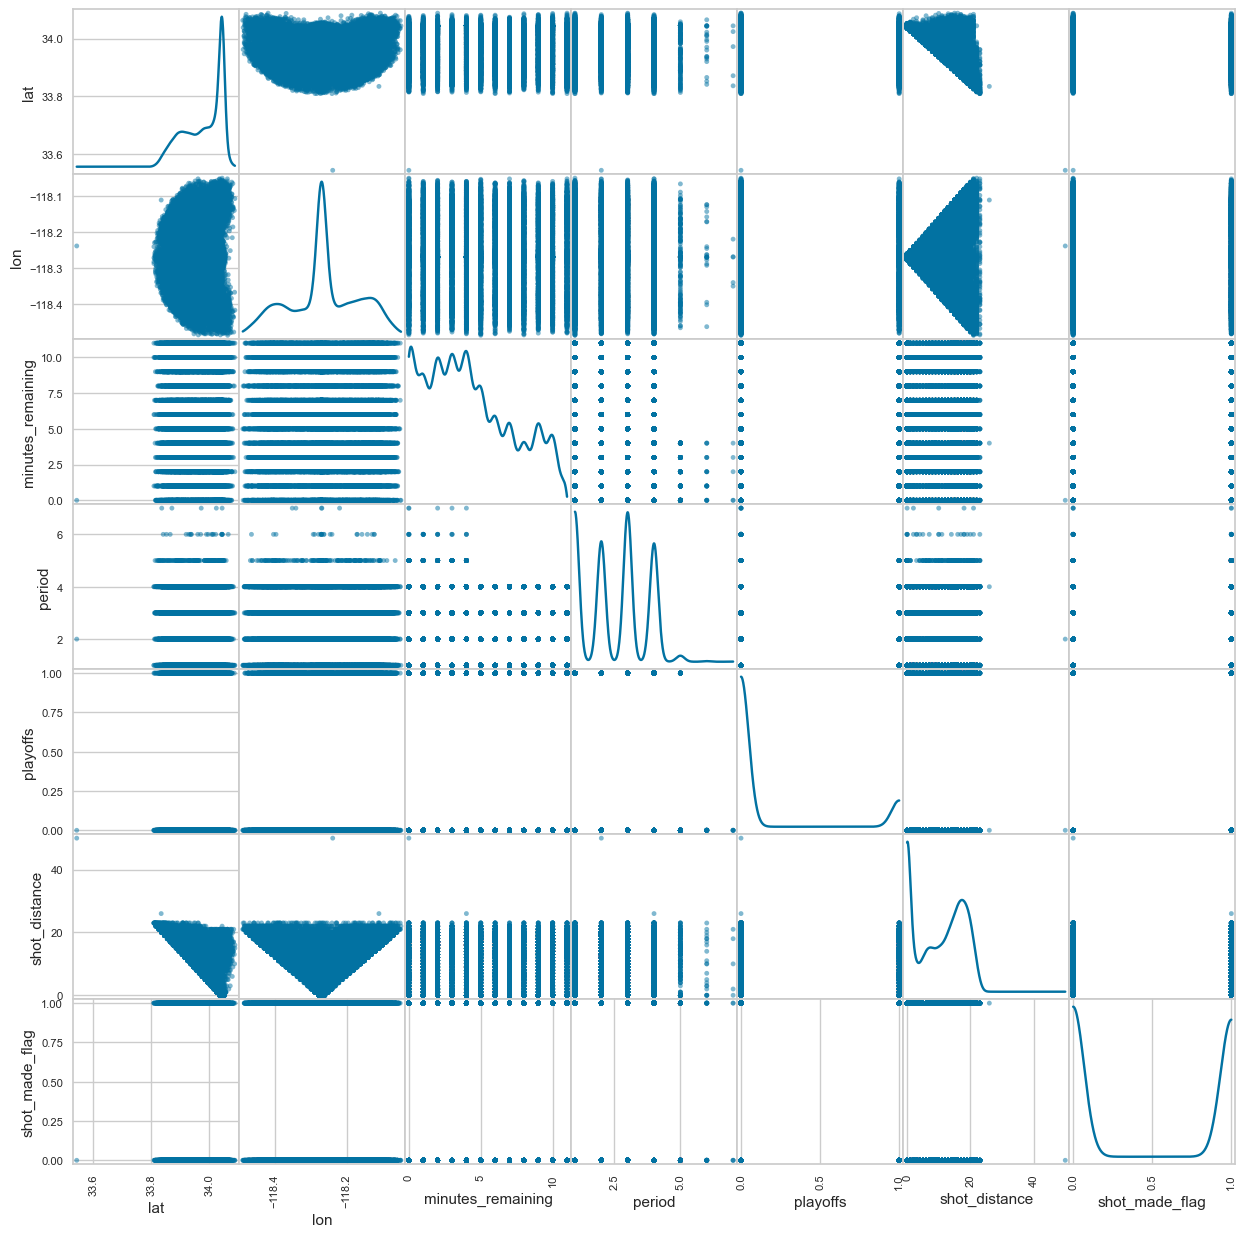

In [5]:
pd.plotting.scatter_matrix(df_dev_preview, diagonal='kde', figsize=(15,15))

In [6]:
cvfold = 10

def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=cvfold,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    return plt.gcf()

In [7]:
train_size = 0.8
test_size = 0.2

with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    
    df_dev_run = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')
    df_dev_run = df_dev_run[data_cols].copy()
    df_dev_run.dropna(inplace=True)
    df_dev_run.to_parquet('../data/processed/data_filtered.parquet')

    x_data = df_dev_run.drop(columns=target_col)
    y_data = df_dev_run[target_col]

    xtrain, xtest, ytrain, ytest = train_test_split(x_data, y_data, train_size=train_size, test_size=test_size, stratify=y_data, random_state=42)
    
    xtrain[target_col] = ytrain
    xtest[target_col] = ytest

    xtrain.to_parquet('../data/processed/data_train.parquet')
    xtest.to_parquet('../data/processed/data_test.parquet')

    mlflow.log_params(
        {
            'perc_test': test_size,
            'colunas_selecionadas': data_cols
        }
    )
    mlflow.log_metrics(
        {
            'qtd_linhas_treino': xtrain.shape[0],
            'qtd_linhas_teste': xtest.shape[0]
        }
    )

In [8]:
#mlflow.end_run() #executar quando der erro de run ativo

,Description,Value
0,Session id,5505
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5338,0.5110,0.5864,0.5101,0.5455,0.0716,0.0724,0.3410
lr,Logistic Regression,0.5784,0.5996,0.4920,0.5673,0.5268,0.1502,0.1515,0.5010


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Scoring: f1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5447,0.5210,0.6004,0.5201,0.5574,0.0937,0.0947


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
Scoring: f1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5714,0.5955,0.4729,0.5606,0.5130,0.1351,0.1367


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5669,0.5000,0.4238,0.5607,0.4827,0.1224,0.1259
1,0.5909,0.5000,0.4522,0.5932,0.5132,0.1713,0.1760
2,0.5884,0.5000,0.4310,0.5954,0.5000,0.1652,0.1715
3,0.5490,0.5000,0.4232,0.5351,0.4726,0.0879,0.0898
4,0.5779,0.5000,0.3935,0.5865,0.4710,0.1420,0.1499
5,0.5613,0.5000,0.3884,0.5584,0.4581,0.1092,0.1143
6,0.5564,0.5000,0.3832,0.5510,0.4521,0.0991,0.1038
7,0.5681,0.5000,0.4168,0.5647,0.4796,0.1245,0.1288
8,0.5709,0.5000,0.4160,0.5689,0.4806,0.1298,0.1344


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5447,0.5210,0.6004,0.5201,0.5574,0.0937,0.0947


2024/04/18 19:29:56 WARNING mlflow.sklearn: Model was missing function: predict-proba. Not logging python_function flavor!


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'model_kobe' already exists. Creating a new version of this model...
Created version '2' of model 'model_kobe'.


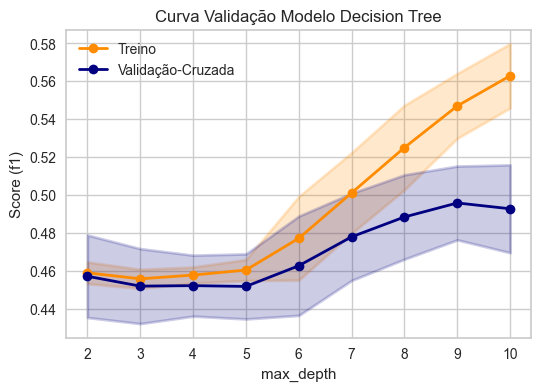

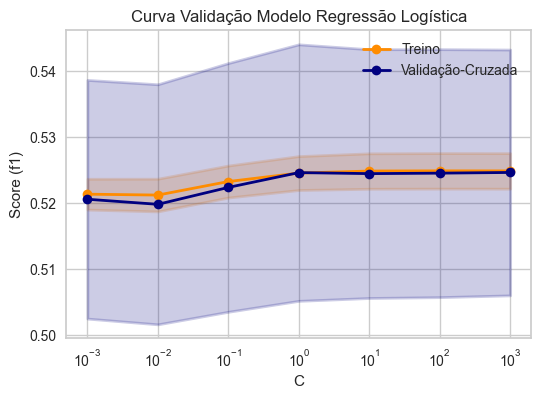

In [9]:
registered_model_name = 'model_kobe'
nexamples = 5
model_version = -1

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):

  exp = pc.setup(
    data = xtrain,
    target = target_col,
    test_data = xtest,
    normalize = True,
    log_experiment = False
  )

  logistic_regression = 'lr'
  decision_tree = 'dt'
  models_to_compare = [logistic_regression, decision_tree]
  sorting_metric = 'f1'

  list_models = exp.compare_models(models_to_compare, n_select=len(models_to_compare), sort=sorting_metric)

  plot_parameter_validation_curve(xtrain.drop(target_col, axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}, list_models[0], 'Decision Tree', 'f1', logx=False)
  plt_file_vc_dt = 'dt_validation_curve.png'
  plt.savefig(plt_file_vc_dt)
  mlflow.log_artifact(plt_file_vc_dt)

  yhat_test = exp.predict_model(list_models[0])
  mlflow.log_metrics({
      'dt_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
      'dt_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)	
  })


  plot_parameter_validation_curve(xtrain.drop(target_col, axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, list_models[1], 'Regressão Logística', 'f1', logx=True)
  plt_file_vc_lr = 'rl_validation_curve.png'
  plt.savefig(plt_file_vc_lr)
  mlflow.log_artifact(plt_file_vc_lr)

  yhat_test = exp.predict_model(list_models[1])
  mlflow.log_metrics({
      'lr_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
      'lr_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
  })


  tuned_model = exp.tune_model(
    list_models[0],
    optimize='f1',
    search_library='scikit-learn',
    search_algorithm='random',
    n_iter=4
  )

  yhat_test = exp.predict_model(tuned_model, raw_score=True) #para adicionar o predict_score, foi adicionar o parâmetro raw_score=True

  mlflow.log_metrics({
      'final_model_log_loss': log_loss(yhat_test[target_col], yhat_test.prediction_label),
      'final_model_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)	
  })

  yhat_test.to_parquet('../data/processed/prediction_test.parquet')
  mlflow.log_artifact('../data/processed/prediction_test.parquet')


  final_model = exp.finalize_model(tuned_model)

  pc.save_model(final_model, f'./{registered_model_name}')
  model_pipeline = exp.load_model(f'./{registered_model_name}')
  model_features = list(xtrain.drop(columns=target_col).columns)
  model_signature = infer_signature(xtrain[model_features], model_pipeline.predict_proba(xtrain.drop(columns=target_col)))
  input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
  mlflow.sklearn.log_model(
    sk_model = model_pipeline,
    artifact_path = 'sklearn-model',
    registered_model_name = registered_model_name,
    signature = model_signature,
    input_example = input_example,
    pyfunc_predict_fn = 'predict-proba'
  )
  client = MlflowClient()
  if model_version == -1:
    model_version = client.get_latest_versions(registered_model_name)[-1].version
  client.set_registered_model_alias(
    name = registered_model_name,
    alias = 'staging',
    version = model_version,
    
  )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5447,0.5210,0.6004,0.5201,0.5574,0.0937,0.0947


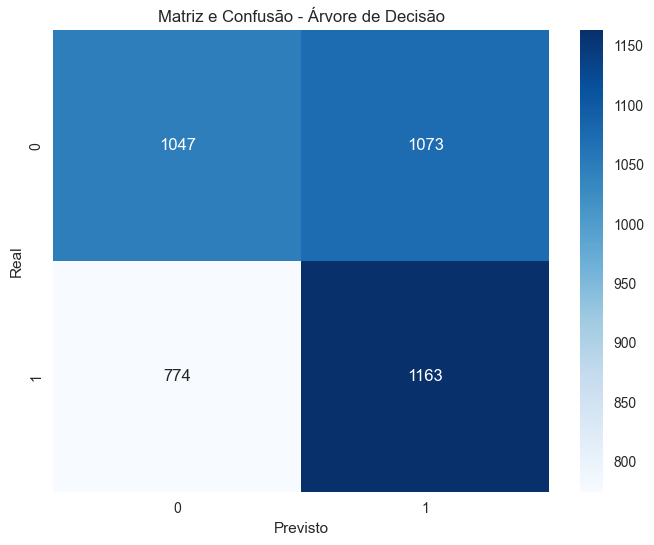

In [10]:
ypred_matrix = exp.predict_model(list_models[0]).prediction_label
ytest_matrix = xtest[target_col]

cm = confusion_matrix(ytest, ypred_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz e Confusão - Árvore de Decisão')
plt.show()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5714,0.5955,0.4729,0.5606,0.5130,0.1351,0.1367


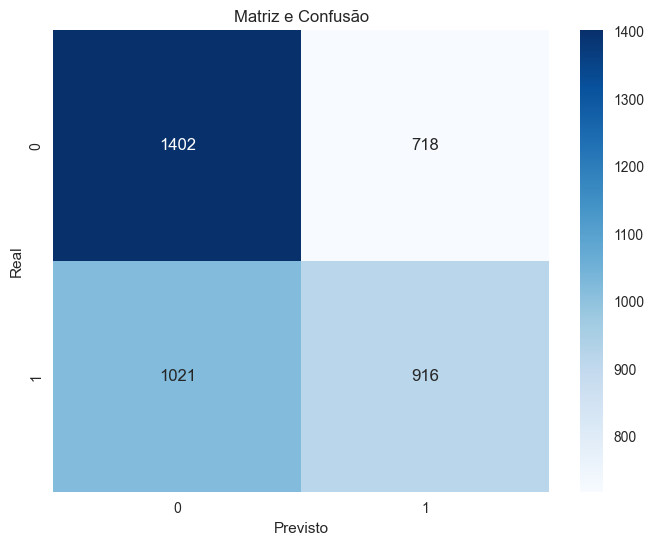

In [11]:
ypred_matrix = exp.predict_model(list_models[1]).prediction_label
ytest_matrix = xtest[target_col]

cm = confusion_matrix(ytest, ypred_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz e Confusão')
plt.show()

           lat       lon  minutes_remaining  period  playoffs  shot_distance
30558  33.8883 -118.3828                 11       3         1             19
520    34.0213 -118.1598                  2       3         0             11
25613  33.9833 -118.1208                 10       2         0             16
15368  34.0443 -118.2698                  0       4         0              0
9175   34.0443 -118.2698                  0       1         0              0
...        ...       ...                ...     ...       ...            ...
323    34.0313 -118.2988                 11       2         0              3
1043   34.0423 -118.1848                  6       1         0              8
23222  34.0443 -118.2698                  3       4         0              0
14718  33.9343 -118.3778                  5       1         0             15
24021  33.8503 -118.2818                  0       1         0             19

[4057 rows x 6 columns]
Top Features
 ['shot_distance' 'playoffs' 'period' 

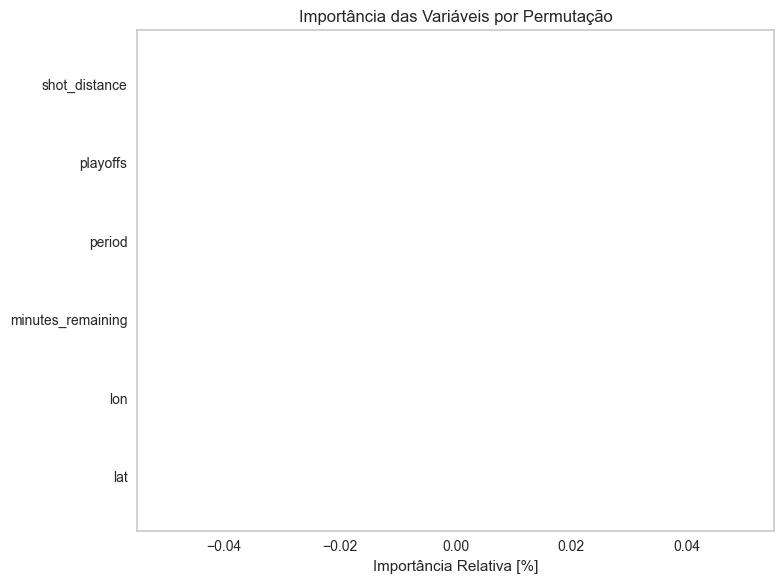

In [12]:
ntop=4

data_cols_permutation = copy.deepcopy(data_cols)
data_cols_permutation.remove(target_col)

xtest_permutartion = copy.deepcopy(xtest)
xtest_permutartion = xtest_permutartion.drop(columns=target_col, axis=1)

print(xtest_permutartion)
plt.figure(figsize=(8,6))

r = permutation_importance(list_models[0], xtest_permutartion, ytest,
                           n_repeats=30,
                           random_state=0)
importance =  r.importances_mean
idx = np.argsort(importance)
plt.barh(np.arange(idx.shape[0]), importance[idx]*100)
plt.yticks(np.arange(idx.shape[0]), np.array(data_cols_permutation)[idx])
plt.title('Importância das Variáveis por Permutação')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()

top_features = np.array(data_cols_permutation)[idx][::-1][:ntop]
print('Top Features\n',top_features)

['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']
           lat       lon  minutes_remaining  period  playoffs  shot_distance
7006   34.0343 -118.1288                  1       2         0             14
20760  33.9723 -118.0808                  0       3         0             20
15143  33.8713 -118.1728                 11       3         0             19
10506  34.0443 -118.2698                 11       2         0              0
21377  33.8543 -118.2698                 11       3         0             19
...        ...       ...                ...     ...       ...            ...
29740  34.0523 -118.0718                  9       3         1             19
23272  34.0443 -118.2698                  0       1         0              0
6023   34.0523 -118.0838                  2       3         0             18
1104   34.0403 -118.3618                  3       3         0              9
27185  33.8573 -118.3958                  6       1         1             22



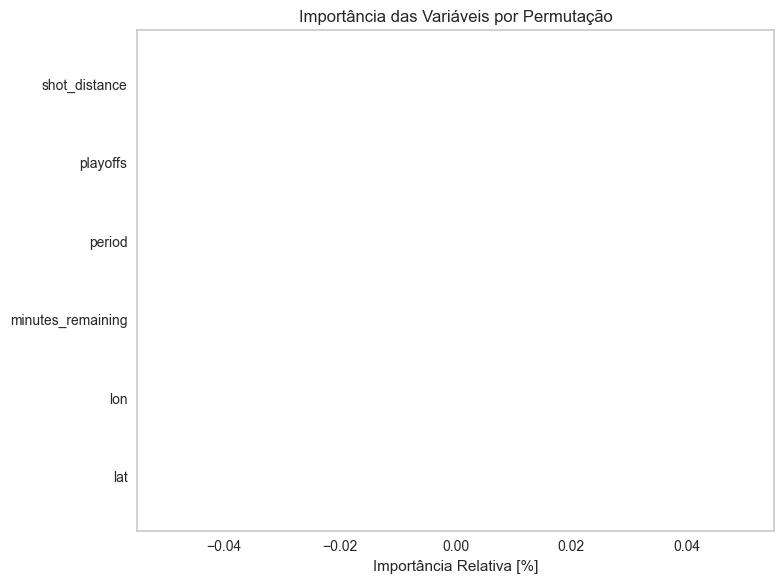

In [13]:
ntop=4

data_cols_permutation = copy.deepcopy(data_cols)
data_cols_permutation.remove(target_col)

print(data_cols_permutation)

xtest_permutartion = copy.deepcopy(xtrain)
xtest_permutartion = xtest_permutartion.drop(columns=target_col, axis=1)

print(xtest_permutartion)
plt.figure(figsize=(8,6))

r = permutation_importance(list_models[0], xtest_permutartion, ytrain,
                           n_repeats=30,
                           random_state=0)
importance =  r.importances_mean
idx = np.argsort(importance)
plt.barh(np.arange(idx.shape[0]), importance[idx]*100)
plt.yticks(np.arange(idx.shape[0]), np.array(data_cols_permutation)[idx])
plt.title('Importância das Variáveis por Permutação')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()

top_features = np.array(data_cols_permutation)[idx][::-1][:ntop]
print('Top Features\n',top_features)

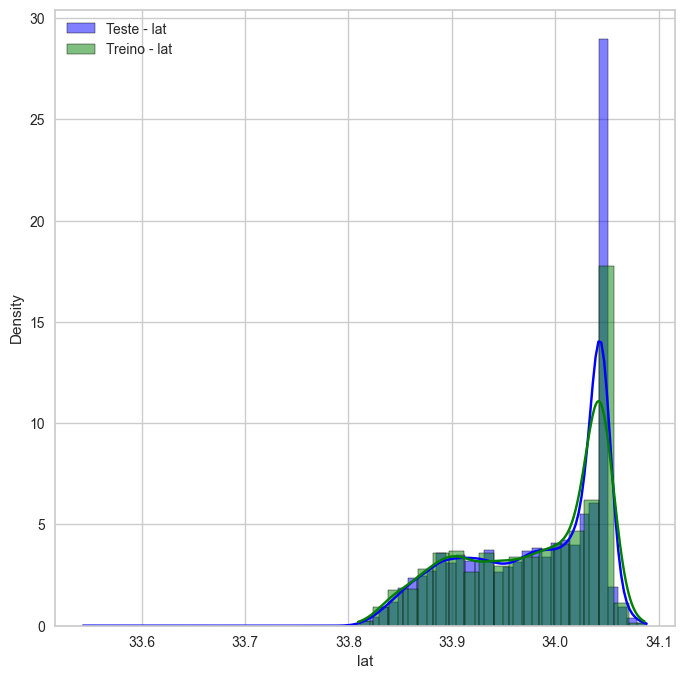

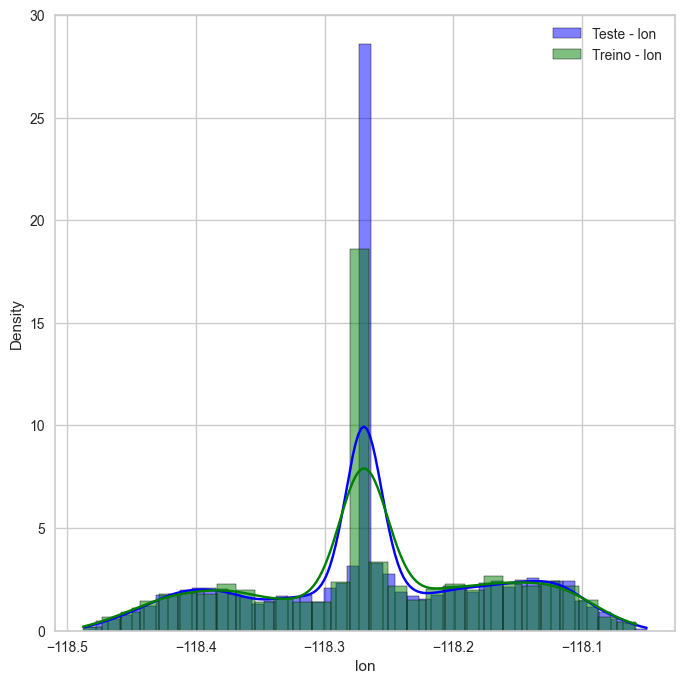

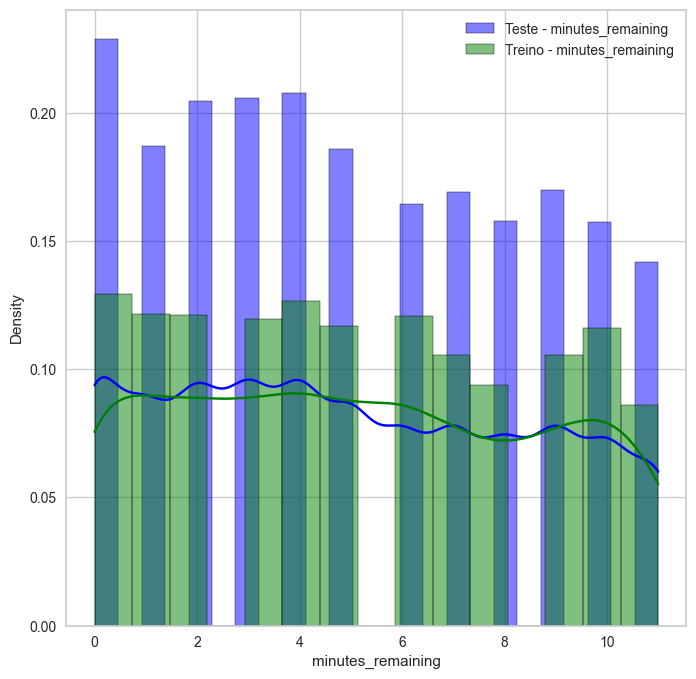

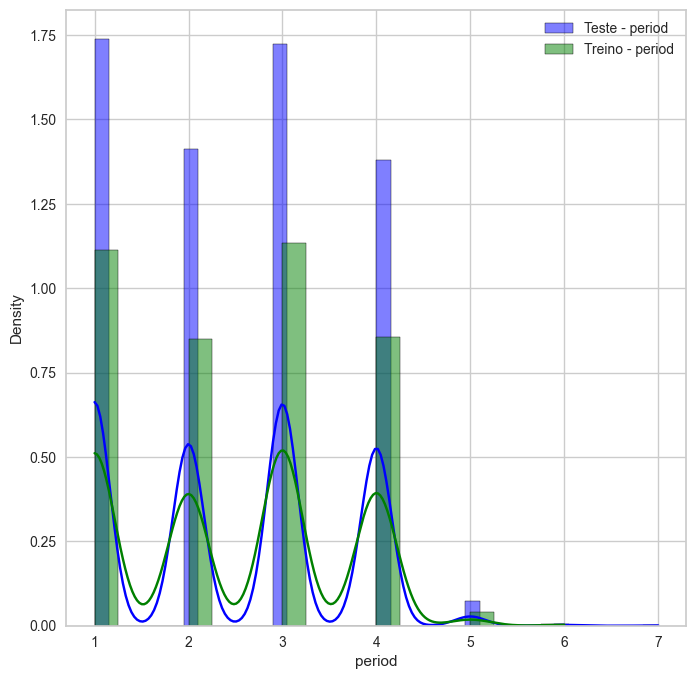

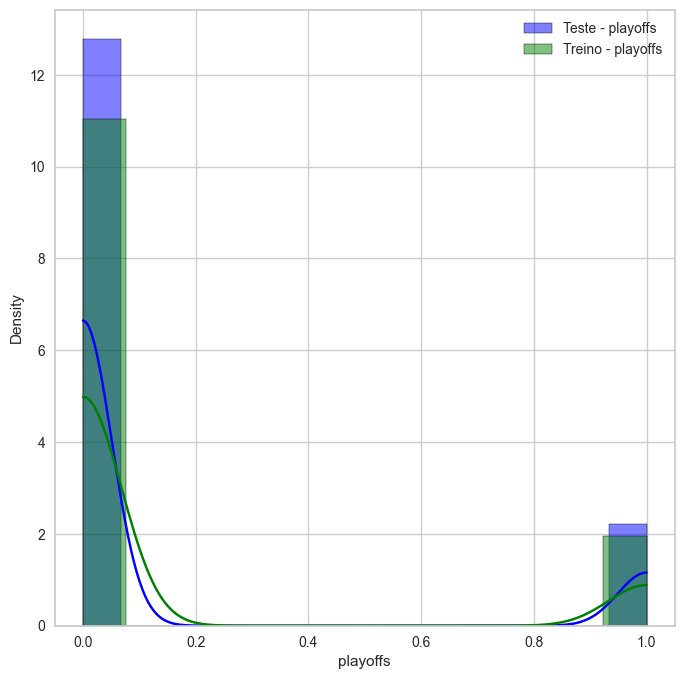

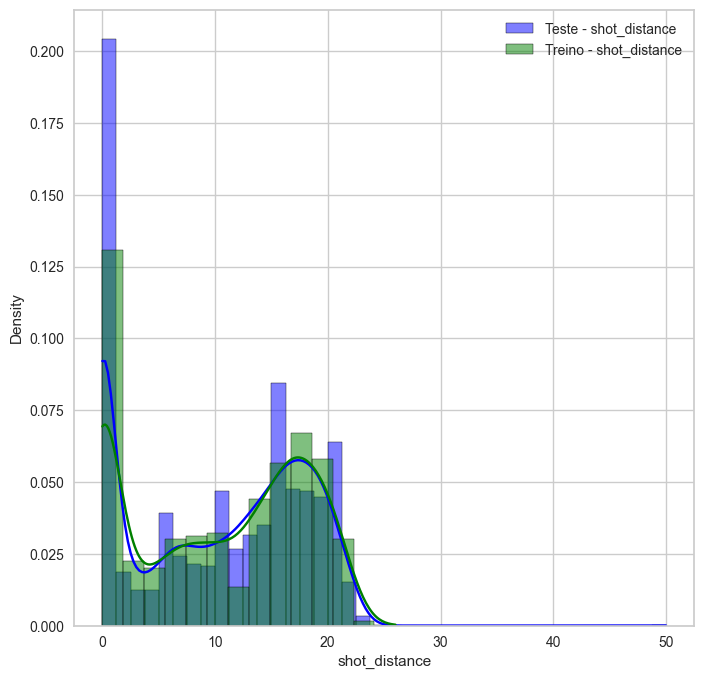

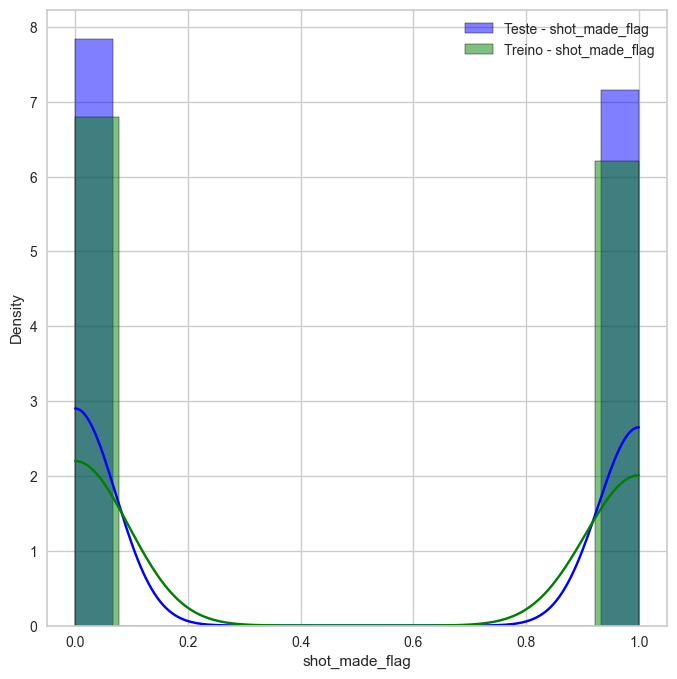

In [14]:
for col in data_cols:
    fig, ax = plt.subplots(figsize=(8, 8))

    sns.histplot(xtrain[col], label=f'Teste - {col}', kde=True, stat='density', ax=ax, color='blue')
    sns.histplot(xtest[col], label=f'Treino - {col}', kde=True, stat='density', ax=ax, color='green')

    ax.legend()
    plt.show()

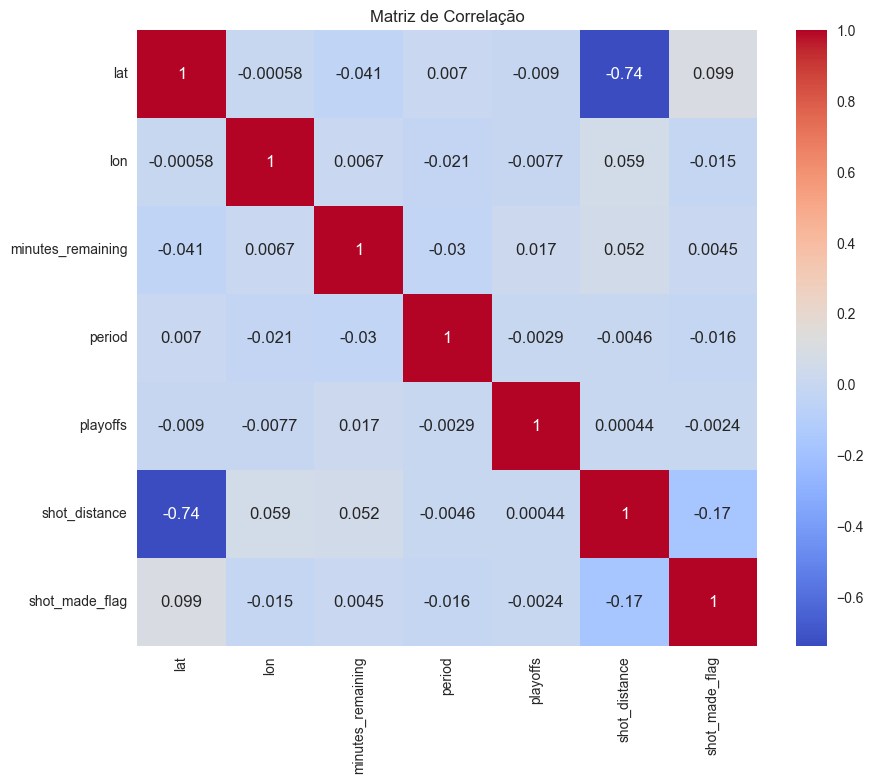

In [15]:
correlation_matrix = xtrain.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

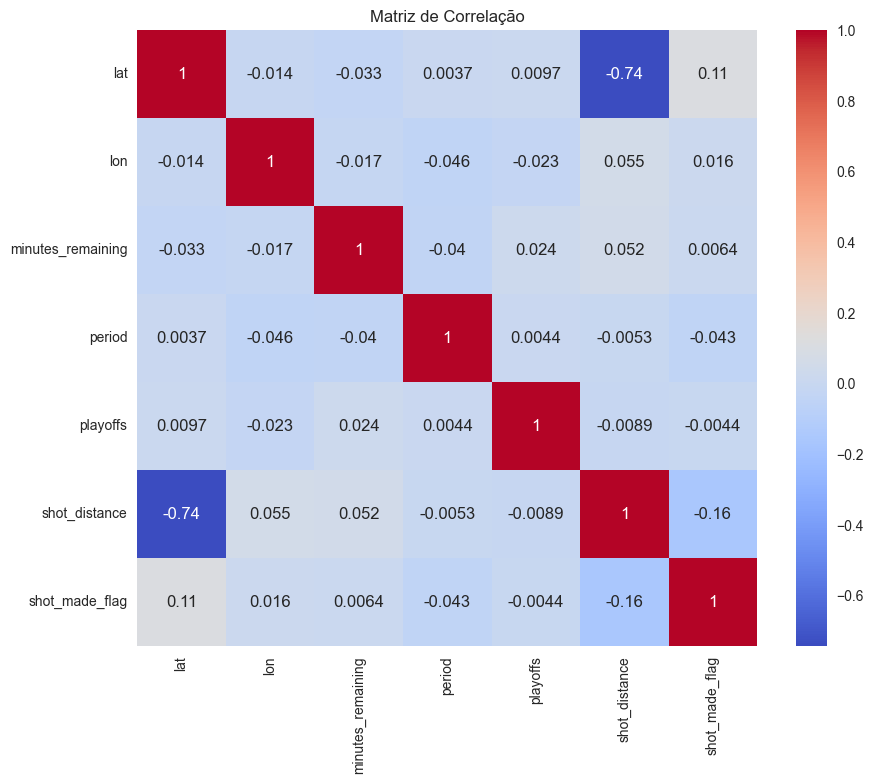

In [16]:
correlation_matrix = xtest.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5447,0.5210,0.6004,0.5201,0.5574,0.0937,0.0947


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5714,0.5955,0.4729,0.5606,0.5130,0.1351,0.1367


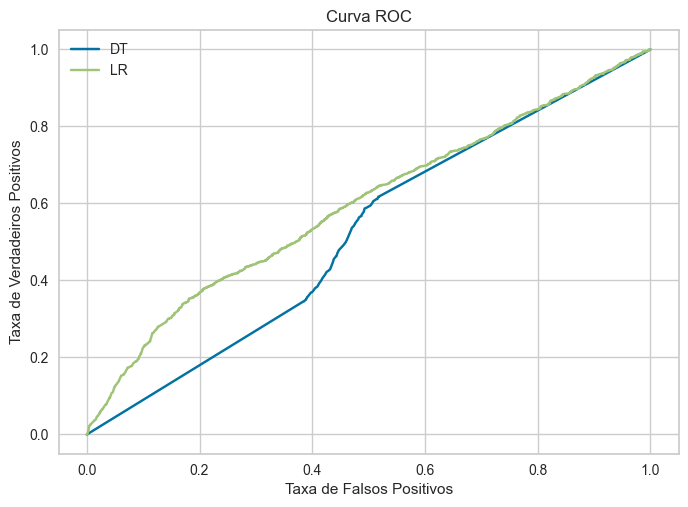

In [17]:
yhat_test_dt = exp.predict_model(list_models[0], raw_score=True)
fpr, tpr, thr = roc_curve(yhat_test_dt[target_col], yhat_test_dt.prediction_score_1)

yhat_test_rl = exp.predict_model(list_models[1], raw_score=True)
fpr2, tpr2, thr2 = roc_curve(yhat_test_rl[target_col], yhat_test_rl.prediction_score_1)

plt.plot(fpr, tpr, label='DT')
plt.plot(fpr2, tpr2, label='LR')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')

plt.legend()